In [1]:
import pandas as pd
import os

BASE_DIR = 'output/nmla/selected_markers/'

genes, clins = None, None

gene_name = pd.read_csv('output/ensg_x_gene_name.csv', sep=',')

for filename in os.listdir(BASE_DIR):
    if '.csv' in filename:
        
        df = pd.read_csv(os.path.join(BASE_DIR, filename), sep=',')
        
        if 'gene' in filename:
            genes = df if genes is None else pd.concat([genes, df])
        else:
            clins = df if clins is None else pd.concat([clins, df])

clins = clins.reset_index(drop=True)
genes = genes.reset_index(drop=True)

clins = clins.groupby('clinical_marker').agg(['mean', 'count'])
genes = genes.groupby('gene').agg(['mean', 'count'])

for d in [clins, genes]:
    
    d.columns = ['_'.join(c) for c in d.columns]
    
    d.index.set_names('marker', inplace=True)
    
    d.reset_index(inplace=True)

    d.drop(columns=['pvalue_count'], inplace=True)

    d.rename(columns={'entropy_count': 'count'}, inplace=True)

gene_name = pd.read_csv('output/ensg_x_gene_name.csv', sep=',')

genes = genes.merge(gene_name, left_on='marker', right_on='marker')

genes = genes.drop(columns=['marker']).rename(columns={'genemania': 'marker'})
    
genes['type'] = 'Gene'
clins['type'] = 'Clinical'

nodes = pd.concat([clins, genes])

nodes['pvalue_mean'] = 1 - (nodes['pvalue_mean']  - nodes['pvalue_mean'] .min()) / (nodes['pvalue_mean'] .max() - nodes['pvalue_mean'] .min())

patterns = {'ENSG[0]+': '',
            'percent_plasma_cells_': '',  
            'percent_plama_cells_': '', 
            'first_line_transplant': 'transplant',
            'beta_2_.+': 'beta_2',
            'percent_': ''
           }

for k, v in patterns.items():
    nodes['marker'] = nodes['marker'].str.replace(k, v)

print(nodes.shape)
nodes = nodes[['marker', 'count', 'entropy_mean', 'pvalue_mean', 'type']]
nodes.head()

(81, 5)


C:\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



,marker,count,entropy_mean,pvalue_mean,type
0,age,6,5.383683,0.711297,Clinical
1,beta_2,10,7.772197,0.987961,Clinical
2,bun,10,5.212972,0.648812,Clinical
3,creatinine,3,7.318210,0.185017,Clinical
4,transplant,10,0.998815,1.000000,Clinical


In [2]:
genes.shape

(70, 5)

In [3]:
ensg_mapping = {}

for i, row in gene_name.iterrows():
    ensg_mapping[row[0]] = row[1]
    
ensg_mapping

{'ENSG00000072786': 'STK10',
 'ENSG00000095587': 'TLL2',
 'ENSG00000102001': 'CACNA1F',
 'ENSG00000102032': 'RENBP',
 'ENSG00000107249': 'GLIS3',
 'ENSG00000108176': 'DNAJC12',
 'ENSG00000112561': 'TFEB',
 'ENSG00000121210': 'KIAA0922',
 'ENSG00000123810': 'B9D2',
 'ENSG00000132965': 'ALOX5AP',
 'ENSG00000134900': 'TPP2',
 'ENSG00000137628': 'DDX60',
 'ENSG00000143515': 'ATP8B2',
 'ENSG00000144061': 'NPHP1',
 'ENSG00000144554': 'FANCD2',
 'ENSG00000147202': 'DIAPH2',
 'ENSG00000150337': 'FCGR1A',
 'ENSG00000150907': 'FOXO1',
 'ENSG00000153956': 'CACNA2D1',
 'ENSG00000155755': 'TMEM237',
 'ENSG00000156535': 'CD109',
 'ENSG00000158555': 'GDPD5',
 'ENSG00000163001': 'CFAP36',
 'ENSG00000163521': 'GLB1L',
 'ENSG00000165698': 'SPACA9',
 'ENSG00000167074': 'TEF',
 'ENSG00000168918': 'INPP5',
 'ENSG00000170961': 'HAS2',
 'ENSG00000174628': 'IQCK',
 'ENSG00000182511': 'FES',
 'ENSG00000184990': 'SIVA1',
 'ENSG00000185621': 'LMLN',
 'ENSG00000186976': 'EFCAB6',
 'ENSG00000189167': 'ZAR1L',
 'EN

In [4]:
f1 = sorted([filename for filename in os.listdir(BASE_DIR) if '.csv' in filename and 'gene' in filename])
f2 = sorted([filename for filename in os.listdir(BASE_DIR) if '.csv' in filename and 'clin' in filename])
    
edges = {c: [] for c in ['n1', 'n2', 'count']}

for ff1, ff2 in zip(f1, f2):
    
    gen, cli = pd.read_csv(os.path.join(BASE_DIR, ff1)), pd.read_csv(os.path.join(BASE_DIR, ff2))
    
    for c1 in gen['gene'].tolist():
        for c2 in cli['clinical_marker'].tolist():
            try:
                edges['n1'].append(ensg_mapping[c1])
                edges['n2'].append(c2)
                edges['count'].append(1)
            except KeyError:
                sss.add(c1)
    
    for c1 in gen['gene'].tolist():
        for c2 in gen['gene'].tolist():
            if c1 != c2:
                edges['n1'].append(ensg_mapping[c1])
                edges['n2'].append(ensg_mapping[c2])
                edges['count'].append(1)
    
    for c1 in cli['clinical_marker'].tolist():
        for c2 in cli['clinical_marker'].tolist():
            if c1 != c2:
                edges['n1'].append(c1)
                edges['n2'].append(c2)
                edges['count'].append(1)

edges = pd.DataFrame(edges).groupby(['n1', 'n2']).sum().reset_index()

for c in ['n1', 'n2']:
    for k, v in patterns.items():
        edges[c] = edges[c].str.replace(k, v)

print(edges.shape)

edges.head()


(2973, 3)


,n1,n2,count
0,AC097103.1,ADH6,1
1,AC097103.1,AL391840.1,1
2,AC097103.1,ALOX5AP,2
3,AC097103.1,AP002026.1,1
4,AC097103.1,B9D2,1


In [5]:
import networkx as nx
import pandas as pd
import itertools
import copy

In [6]:
g = nx.Graph()

# Add edges and edge attributes
for i, elrow in edges.iterrows():
    g.add_edge(elrow[0], elrow[1], attr_dict=elrow[2:].to_dict())
    
# Edge list example
print(elrow[0]) # node1
print(elrow[1]) # node2
print(elrow[2:].to_dict()) # edge attribute dict

wbc_x10_10_9_l
ldh
{'count': 1}


In [7]:
# Add node attributes
for i, nlrow in nodes.iterrows():
    g.node[nlrow['marker']].update(nlrow[1:].to_dict())
print(nlrow)

marker          RP11-329B9.5
count                     14
entropy_mean         2.06567
pvalue_mean         0.997263
type                    Gene
Name: 69, dtype: object


In [8]:
print('# of edges: {}'.format(g.number_of_edges()))
print('# of nodes: {}'.format(g.number_of_nodes()))

# of edges: 1752
# of nodes: 81


In [23]:
export = {'n1': [], 'n2': [], 'weight': []}

for e in g.edges(data=True):
    export['n1'].append(e[0])
    export['n2'].append(e[1])
    export['weight'].append(e[2]['attr_dict']['count'])
    
export = pd.DataFrame(export)
    
export.to_csv('output/graph/edges.csv', sep=',', index=False)

export.head()

,n1,n2,weight
0,AC097103.1,ADH6,1
1,AC097103.1,AL391840.1,1
2,AC097103.1,ALOX5AP,2
3,AC097103.1,AP002026.1,1
4,AC097103.1,B9D2,1


In [24]:
export = {'node': [], 'weight': [], 'entropy_mean': [], 'pvalue_mean': [], 'type': []}

for e in g.nodes(data=True):
    export['node'].append(e[0])
    export['weight'].append(e[1]['count'])
    export['entropy_mean'].append(e[1]['entropy_mean'])
    export['pvalue_mean'].append(e[1]['pvalue_mean'])
    export['type'].append(e[1]['type'])
    
export = pd.DataFrame(export)
    
export.to_csv('output/graph/node.csv', sep=',', index=False)

export.head()

,node,weight,entropy_mean,pvalue_mean,type
0,AC097103.1,4,2.097457,0.993387,Gene
1,ADH6,2,6.245015,0.983768,Gene
2,AL391840.1,8,4.422011,0.991982,Gene
3,ALOX5AP,6,8.754053,0.991918,Gene
4,AP002026.1,2,8.284591,0.993227,Gene


In [10]:
import pickle as pkl

with open('output/initial_graph_position.pkl', 'rb') as file:
    initial_pos = pkl.load(file)

C:\Anaconda3\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


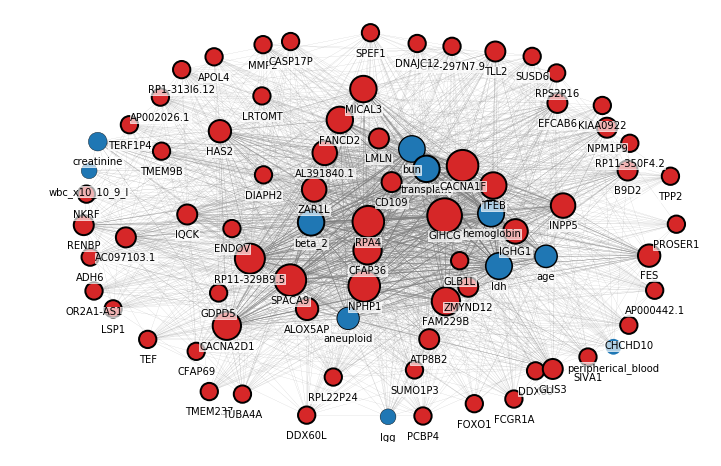

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(12, 8))

pos = nx.spring_layout(g, k = 5.1, scale=10, iterations=100, weight='count')
pos_ = copy.deepcopy(pos)

for k in pos:
    pos[k][1] = pos[k][1] + .8

node_color = {'Clinical': 'tab:blue', 'Gene': 'tab:red'}

for t in ['Clinical', 'Gene']:
    nodelist = [n[0] for n in g.nodes(data=True) if n[1]['type'] == t]
    node_size = [n[1]['count'] * 50 + 200 for n in g.nodes(data=True) if n[1]['type'] == t]
    linewidths = [n[1]['pvalue_mean'] * 2 for n in g.nodes(data=True) if n[1]['type'] == t]
    labels = {n[0]: n[0] for n in g.nodes(data=True) if n[1]['type'] == t}
    nx.draw_networkx_labels(g, pos_, labels=labels, verticalalignment='top', bbox=dict(boxstyle='square,pad=0', alpha=.65, edgecolor='white', facecolor='white'), font_size=10)
    nx.draw_networkx_nodes(g, pos, nodelist=nodelist, node_size=node_size, edgecolors='black', linewidths=linewidths, node_color=node_color[t], node_shape=None)
    
nx.draw_networkx_edges(g, pos, edge_color='gray', width=[e[2]['attr_dict']['count'] / 10 for e in g.edges(data=True)])

ax = plt.gca()
ax.axis('off')

plt.show()

fig.savefig('images/feature_graph.png', dpi=100, bbox_inches='tight', transparent="True", pad_inches=0)